<a href="https://colab.research.google.com/github/sandstorm12/RubikaInterviewExam/blob/dev/rubika_interview_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Issues and future work

1. Try oversampling using augmentation

In [ ]:
#@title System check { form-width: "20%" }

!nvidia-smi

Wed Sep 15 13:49:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#@title Installation { form-width: "20%" }

!pip3 install focal-loss

In [2]:
#@title Imports { form-width: "20%"}

import numpy as np
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from focal_loss import SparseCategoricalFocalLoss

In [3]:
#@title Load dataset { form-width: "20%" }

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("x_train: {} y_train: {} x_test: {} y_test: {}".format(
        x_train.shape, y_train.shape, x_test.shape, y_test.shape
    )
)

print("x_train --> max: {} mean: {} min: {}".format(
        np.max(x_train), np.mean(x_train), np.min(x_train)
    )
)

print("y_train --> unique_values: {}".format(
        np.unique(y_train)
    )
)

170508288/170498071 [==============================] - 4s 0us/step
x_train: (50000, 32, 32, 3) y_train: (50000, 1) x_test: (10000, 32, 32, 3) y_test: (10000, 1)
x_train --> max: 255 mean: 120.70756512369792 min: 0
y_train --> unique_values: [0 1 2 3 4 5 6 7 8 9]


In [4]:
#@title Preprocessing { form-width: "20%" }

x_train_preprocessed = tf.keras.applications.densenet.preprocess_input(x_train)
x_test_preprocessed = tf.keras.applications.densenet.preprocess_input(x_test)

print("x_train --> max: {} mean: {} min: {}".format(
        np.max(x_train_preprocessed),
        np.mean(x_train_preprocessed),
        np.min(x_train_preprocessed)
    )
)

x_train --> max: 2.640000104904175 mean: 0.10828698426485062 min: -2.1179039478302


In [12]:
#@title One class separation { form-width: "20%" }

selected_class =  8#@param {type:"integer"}

y_train_one_class = y_train.copy()
y_train_one_class[y_train == selected_class] = 0
y_train_one_class[y_train != selected_class] = 1

y_test_one_class = y_test.copy()
y_test_one_class[y_test == selected_class] = 0
y_test_one_class[y_test != selected_class] = 1

print(np.unique(y_train_one_class))
print(np.unique(y_test_one_class))

[0 1]
[0 1]


In [ ]:
#@title Build model (transfer learning) { form-width: "20%" }

focal_loss = False #@param {type:"boolean"}


model = tf.keras.Sequential()

model.add(
    tf.keras.applications.DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=(32, 32, 3),
    )
)

# for layer in model.layers:
#     layer.trainable = False

model.add(
    tf.keras.layers.Flatten()
)

model.add(
    tf.keras.layers.Dense(512, activation="relu")
)

model.add(
    tf.keras.layers.Dense(128, activation="relu")
)

model.add(
    tf.keras.layers.Dense(2, activation="softmax")
)

loss_func = "sparse_categorical_crossentropy"
if focal_loss:
    loss_func = SparseCategoricalFocalLoss(gamma=2)


model.compile(
    loss=loss_func,
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 7,628,226
Trainable params: 7,544,578
Non-trainable params: 83,648
_________________________________________________________________


In [13]:
#@title Build model (from scratch) { form-width: "20%" }

focal_loss = True #@param {type:"boolean"}
first_layer_filters = 32 #@param {type:"integer"}
second_layer_filters = 64#@param {type:"integer"}
third_layer_filters = 128#@param {type:"integer"}


model = tf.keras.Sequential()

model.add(
    tf.keras.layers.InputLayer((32, 32, 3))
)

model.add(
    tf.keras.layers.Conv2D(first_layer_filters, (3, 3), activation="relu")
)
model.add(
    tf.keras.layers.Conv2D(first_layer_filters, (3, 3), activation="relu")
)
model.add(
    tf.keras.layers.MaxPool2D((2, 2))
)
model.add(
    tf.keras.layers.BatchNormalization()
)

model.add(
    tf.keras.layers.Conv2D(second_layer_filters, (3, 3), activation="relu")
)
model.add(
    tf.keras.layers.Conv2D(second_layer_filters, (3, 3), activation="relu")
)
model.add(
    tf.keras.layers.MaxPool2D((2, 2))
)
model.add(
    tf.keras.layers.BatchNormalization()
)

model.add(
    tf.keras.layers.Conv2D(third_layer_filters, (3, 3), activation="relu")
)
model.add(
    tf.keras.layers.Conv2D(third_layer_filters, (3, 3), activation="relu")
)

model.add(
    tf.keras.layers.Flatten()
)
model.add(
    tf.keras.layers.BatchNormalization()
)

model.add(
    tf.keras.layers.Dense(2, activation="softmax")
)

loss_func = "sparse_categorical_crossentropy"
if focal_loss:
    loss_func = SparseCategoricalFocalLoss(gamma=2)

model.compile(
    loss=loss_func,
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)         

In [14]:
#@title Train { form-width: "20%" }
class_weight = False #@param {type:"boolean"}
save_on_each_epoch = True #@param {type:"boolean"}
epochs =  50#@param {type:"integer"}
batch_size = 32 #@param {type:"integer"}

weights = None
if class_weight:
    weights = {0: 1., 1: .1}

    import sklearn
    weights = sklearn.utils.class_weight.compute_class_weight(
        "balanced",
        np.unique(y_train_one_class),
        y_train_one_class.ravel()
    )
    weights = {0: weights[0], 1: weights[1]}
    print(weights)
    

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("epoch", epoch)
        y_pred = np.argmax(model.predict(x_test_preprocessed), axis=1)
        print(classification_report(y_test_one_class, y_pred))

        if save_on_each_epoch:
            self.model.save("model_epoch_{}.hd5".format(epoch))


model.fit(
    x_train_preprocessed, y_train_one_class,
    validation_split=.1, batch_size=batch_size, epochs=epochs,
    callbacks=[CustomCallback()], class_weight=weights
)

Epoch 1/50
1407/1407 [==============================] - 20s 13ms/step - loss: 0.0625 - accuracy: 0.9123 - val_loss: 0.0400 - val_accuracy: 0.9370
epoch 0
              precision    recall  f1-score   support

           0       0.68      0.71      0.70      1000
           1       0.97      0.96      0.97      9000

    accuracy                           0.94     10000
   macro avg       0.83      0.84      0.83     10000
weighted avg       0.94      0.94      0.94     10000

INFO:tensorflow:Assets written to: model_epoch_0.hd5/assets
Epoch 2/50
1407/1407 [==============================] - 18s 13ms/step - loss: 0.0389 - accuracy: 0.9444 - val_loss: 0.0318 - val_accuracy: 0.9554
epoch 1
              precision    recall  f1-score   support

           0       0.86      0.64      0.74      1000
           1       0.96      0.99      0.97      9000

    accuracy                           0.95     10000
   macro avg       0.91      0.82      0.86     10000
weighted avg       0.95      0.95

In [8]:
#@title Evaluation { form-width: "20%" }

load = True #@param {type:"boolean"}
model_epoch =  17#@param {type:"integer"}

if load:
    model = tf.keras.models.load_model(
        "model_epoch_{}.hd5".format(model_epoch)
    )

y_pred = np.argmax(model.predict(x_test_preprocessed), axis=1)


print("Classification report: \n{}".format(
        classification_report(y_test_one_class, y_pred)
    )
)

print("Confusion matrix: \n{}".format(
        confusion_matrix(y_test_one_class, y_pred)
    )
)

Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      1000
           1       0.98      0.99      0.98      9000

    accuracy                           0.97     10000
   macro avg       0.95      0.89      0.92     10000
weighted avg       0.97      0.97      0.97     10000

Confusion matrix: 
[[ 797  203]
 [  70 8930]]


In [9]:
#@title Feature extraction { form-width: "20%" }

topless_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(model.layers[-2].name).output
)

features = topless_model.predict(x_test_preprocessed)

print("Features shape: {}".format(features.shape))

Features shape: (10000, 128)


In [10]:
#@title Dimensionality reduction using TSN-e { form-width: "20%" }

from sklearn.manifold import TSNE

features_2d= TSNE(n_components=2).fit_transform(features)

print("New features shape: {}".format(features_2d.shape))

New features shape: (10000, 2)


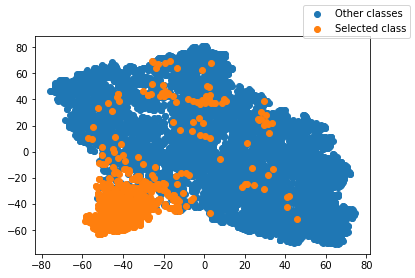

In [11]:
#@title Feature visualization { form-width: "20%" }

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(
    features_2d[(y_test_one_class==1).ravel(), 0],
    features_2d[(y_test_one_class==1).ravel(), 1],
    label="Other classes"
)
ax.scatter(
    features_2d[(y_test_one_class==0).ravel(), 0],
    features_2d[(y_test_one_class==0).ravel(), 1],
    label="Selected class"
)
fig.legend()
fig.show()

fig.savefig('plot.png', format='png', dpi=1200)